In [1]:
from numpyro.distributions import constraints
import numpyro as npy
from jax import numpy as jnp
from jax.lax import scan
from ghgf.hgf_jax import loop_inputs
from ghgf.model import HGF

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
import os

import jax.numpy as jnp
from jax import random, grad, jit
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import seaborn as sns

## Loading the USD/CHF time series

In [2]:
timeserie = loadtxt(f"/home/nicolas/git/ghgf/tests/data/usdchf.dat")
data = jnp.array([timeserie, jnp.arange(1, len(timeserie) + 1, dtype=float)]).T

## Fitting the HGF model with fixed parameters

In [3]:
jaxhgf = HGF(
    n_levels=2,
    model_type="GRW",
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -13.0, "2": -2.0},
    rho={"1": 0.0, "2": 0.0},
    kappa={"1": 1.0}
)

Fitting the continuous Hierarchical Gaussian Filter (JAX backend) with 2 levels.


In [4]:
jaxhgf.input_data(input_data=data)

In [5]:
node, results = jaxhgf.final

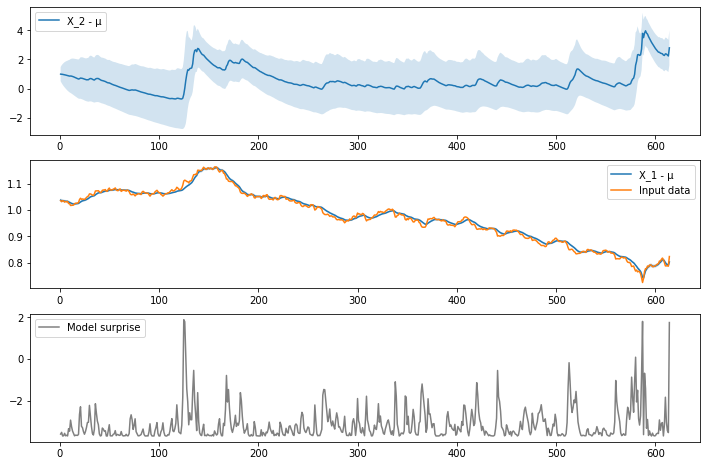

In [6]:
plt.figure(figsize=(12, 8))

plt.subplot(311)
std = jnp.sqrt(1/node[1][2][0][0]["pi"])
plt.plot(results["time"], node[1][2][0][0]["mu"], label="X_2 - μ")
plt.fill_between(
    x=results["time"], 
    y1=node[1][2][0][0]["mu"]-std, 
    y2=node[1][2][0][0]["mu"]+std, 
    alpha=0.2
    )
plt.legend()

plt.subplot(312)
std = jnp.sqrt(1/node[1][0]["pi"])
plt.plot(results["time"], node[1][0]["mu"], label="X_1 - μ")
plt.fill_between(
    x=results["time"], 
    y1=node[1][0]["mu"]-std, 
    y2=node[1][0]["mu"]+std, 
    alpha=0.2
    )
plt.plot(results["time"], results["value"], label="Input data")
plt.legend()

plt.subplot(313)
plt.plot(results["time"], results["surprise"], color="gray", label="Model surprise")

plt.legend()

## Creating the HGF log probability function
We first start by creating the HGF log probability funtion that will be part of the model we want to sample using e.g Hamiltonian Monte Carlo. This model has one input node that is conneted to a value parent and a volatility parent. The function accept values for omegas, rhos and pis parameters. Those values will be sampled from fixed distribution.

In [7]:
@jit
def log_prob(omega_1, omega_2, rho_1, rho_2, pi_1, pi_2, mu_1, mu_2):

        hgf = HGF(
            n_levels=2,
            model_type="GRW",
            initial_mu={"1": mu_1, "2": mu_2},
            initial_pi={"1": pi_1, "2": pi_2},
            omega={"1": omega_1, "2": omega_2},
            rho={"1": rho_1, "2": rho_2},
            kappa={"1": 1.0},
            verbose=False
        )
        
        input_node = hgf.input_node

        ##############
        # Input data #
        ##############

        res_init = (
            input_node,
            {
                "time": jnp.array(0.0),
                "value": jnp.array(0.0),
                "surprise": jnp.array(0.0),
            },
        )

        # This is where the HGF functions are used to scan the input time series
        _, final = scan(loop_inputs, res_init, data)

        _, results = final
        surprise = jnp.sum(results["surprise"])

        return jnp.where(jnp.isnan(surprise), -jnp.inf, -surprise)

The critical part here is the final line

```python
    _last_, final = scan(loop_inputs, res_init, data)
```

this is where the JAX scan function is used to loop across the time series by applying the update HGF function that update the node structure while passing and accumulating previous iteration results. The final results contain a `surprise` time series whose (negative) sum is used to estimate the model fit.

## Automatic differentiation of the log probability
Under the hood, the `log_prob` function wrap a HGF model using JAX code, which make it fast because JIT compiled (note the `@jit` decorator) and optimized for CPU, GPU or TPU depending on the setup. 

In [8]:
log_prob(-10.0, -2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0)  # Fit the HGF to the data, return the negative sum of the surprise

DeviceArray(1929.8743, dtype=float32)

In [9]:
%timeit log_prob(-10.0, -2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0)

32 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


It also make the code fully differentiable. This can be assessed using the JAX `grad` function.

In [10]:
grad(log_prob)(-10.0, -2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0)

DeviceArray(1.6208988, dtype=float32, weak_type=True)

## Parameters estimation using NUTS
### Create the full HGF distribution
Here, the critical part is the `log_prob` method that should return the model surprise.

In [11]:
class HGFDistribution(npy.distributions.Distribution):

    support = constraints.real
    has_rsample = False

    def __init__(
        self, omega_1=None, omega_2=None, rho_1=None, rho_2=None,
        pi_1=None, pi_2=None, mu_1=None, mu_2=None
        ):
        self.omega_1 = omega_1
        self.omega_2 = omega_2
        self.rho_1 = rho_1
        self.rho_2 = rho_2
        self.pi_1 = pi_1
        self.pi_2 = pi_2
        self.mu_1 = mu_1
        self.mu_2 = mu_2
        super().__init__(batch_shape = (1,), event_shape=())

    def sample(self, key, sample_shape=()):
        raise NotImplementedError
        
    def log_prob(self, value):

        return log_prob(
            omega_1=self.omega_1, omega_2=self.omega_2,
            rho_1=self.rho_1, rho_2=self.rho_2,
            pi_1=self.pi_1, pi_2=self.pi_2,
            mu_1=self.mu_1, mu_2=self.mu_2,
            )

### Create the full Bayesian model
Here we use Numpyro to build a full Bayesian model (which is simply a Python function) wrapping the HGF distribution. The omegas, rhos and pis parameter are picked from distributions and the posterior distributions are estimated given the HGF model fit.

In [12]:
def model(data=data):

    omega_1 = npy.sample("omega_1", dist.Normal(-10.0, 4.0))
    omega_2 = npy.sample("omega_2", dist.Normal(-10.0, 4.0))
    rho_1 = jnp.array(0.0)  # npy.sample("rho_1", dist.Normal(0.0, 1.0))
    rho_2 = jnp.array(0.0)  # npy.sample("rho_2", dist.Normal(0.0, 1.0))
    pi_1 = jnp.array(1e4)  # npy.sample("pi_1", dist.HalfNormal(1.0))
    pi_2 = jnp.array(1e1)  # npy.sample("pi_2", dist.HalfNormal(1.0))
    mu_1 = jnp.array(1.04)  # npy.sample("mu_1", dist.Normal(0.0, 1.0))
    mu_2 = jnp.array(1.0)  # npy.sample("mu_2", dist.Normal(0.0, 1.0))

    npy.sample("hgf_log_prob", HGFDistribution(
        omega_1=omega_1, omega_2=omega_2, rho_1=rho_1, rho_2=rho_2,
        pi_1=pi_1, pi_2=pi_2, mu_1=mu_1, mu_2=mu_2)
        )

### Use NUST to sample the model
Here we use NUTS to sample this model, for now using a large nuber of warmups.

In [13]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=2000, num_samples=num_samples)
mcmc.run(
    rng_key_, data=data
)

sample: 100%|██████████| 4000/4000 [01:03<00:00, 62.96it/s, 31 steps of size 1.04e-01. acc. prob=0.93]   


### Plot results

In [14]:
samples_1 = mcmc.get_samples(group_by_chain=True)

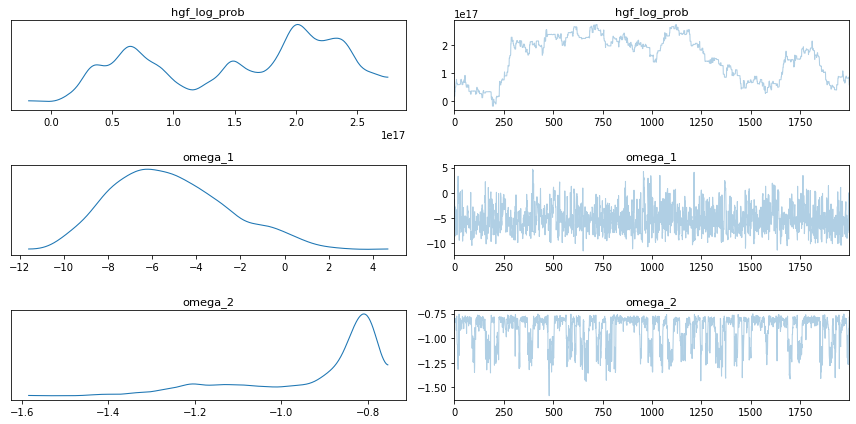

In [15]:
az.plot_trace(samples_1);
plt.tight_layout()

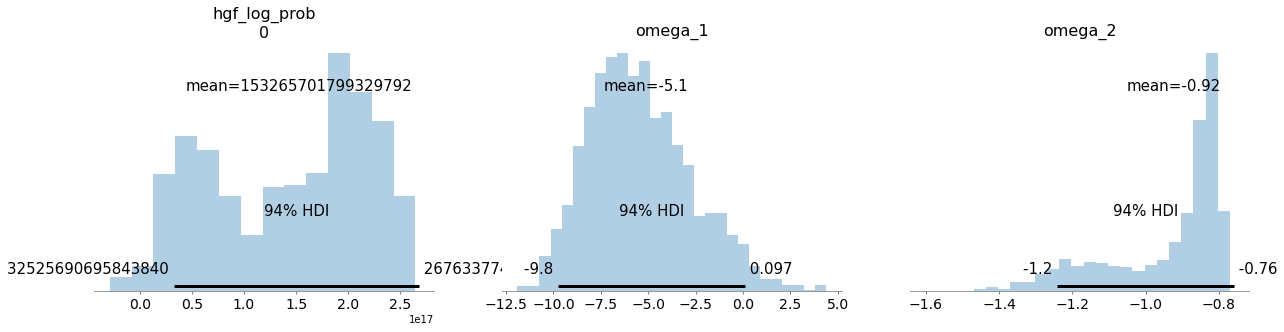

In [16]:
az.plot_posterior(samples_1, kind="hist");

In [17]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
hgf_log_prob[0] 153265701799329792.00 75754349699006464.00 170327923239157760.00 24539811041771520.00 246306616259903488.00      6.85      1.05
        omega_1     -5.13      2.72     -5.42     -9.38     -0.57    772.32      1.00
        omega_2     -0.92      0.16     -0.85     -1.21     -0.77    182.29      1.00

Number of divergences: 72


## Plot MCMC results

In [18]:
mu_1 = 1.0
mu_2 = 1.0
pi_1 = 1.0
pi_2 = 1.0
rho_1 = 0.0
rho_2 = 0.0

# Retrive the parameter traces given the values observed in the last 20 samples
x1_samples, x2_samples, surprise_sample = [], [], []
for omega_2, omega_1 in zip(
    samples_1["omega_2"][0][-100:], samples_1["omega_1"][0][-100:]
    ):
    sample_hgf = HGF(
        n_levels=2,
        model_type="GRW",
        initial_mu={"1": mu_1, "2": mu_2},
        initial_pi={"1": pi_1, "2": pi_2},
        omega={"1": omega_1, "2": omega_2},
        rho={"1": rho_1, "2": rho_2},
        kappa={"1": 1.0},
        verbose=False
        )
    sample_hgf.input_data(input_data=data)
    node, results = sample_hgf.final

    x2_samples.append(node[1][2][0][0]["mu"])
    x1_samples.append(node[1][0]["mu"])
    surprise_sample.append(results["surprise"])

In [19]:
omega_2 = samples_1["omega_2"].mean()
omega_1 = samples_1["omega_1"].mean()

mcmchgf = HGF(
    n_levels=2,
    model_type="GRW",
    initial_mu={"1": mu_1, "2": mu_2},
    initial_pi={"1": pi_1, "2": pi_2},
    omega={"1": omega_1, "2": omega_2},
    rho={"1": rho_1, "2": rho_2},
    kappa={"1": 1.0}
)
mcmchgf.input_data(input_data=data)
node, results = mcmchgf.final

Fitting the continuous Hierarchical Gaussian Filter (JAX backend) with 2 levels.


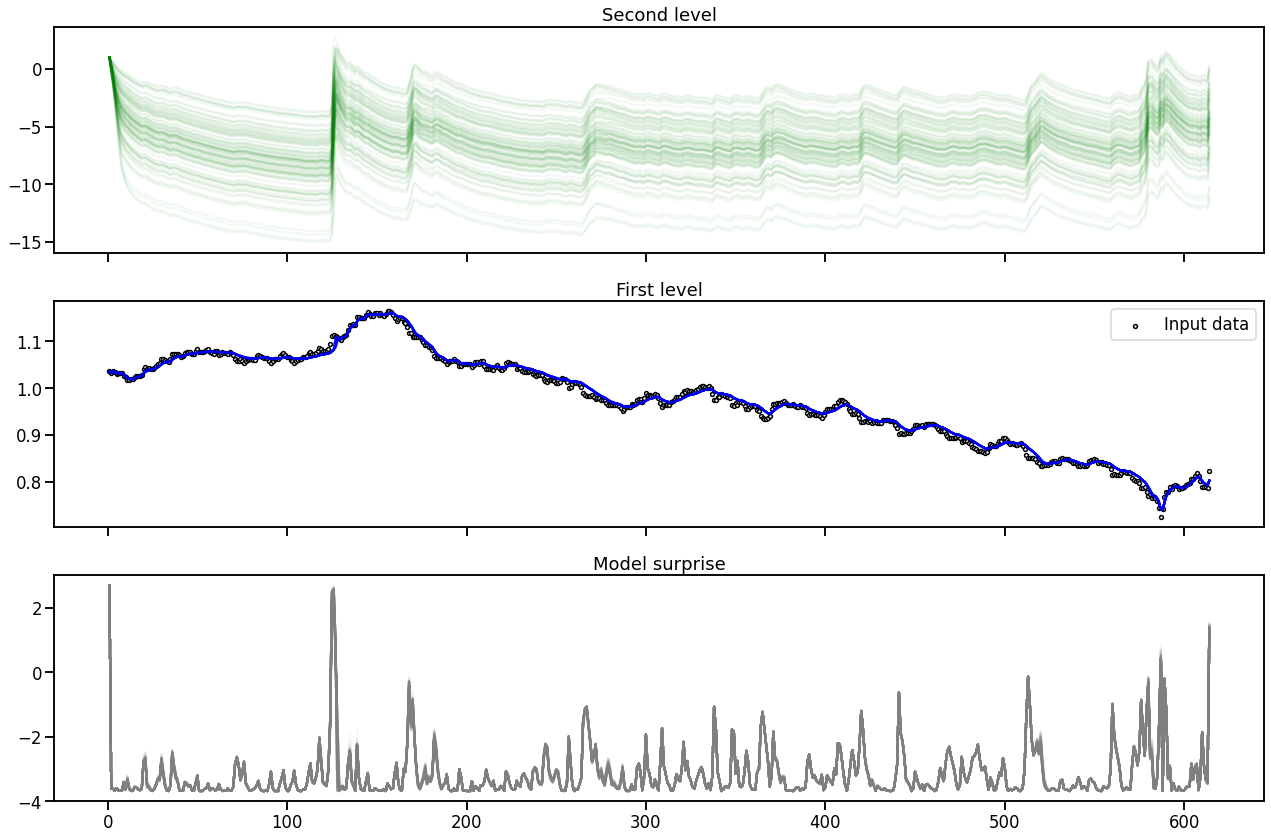

In [20]:
sns.set_context("talk")
fig, axs = plt.subplots(nrows=3, figsize=(18, 12), sharex=True)

# Second level
for s in x2_samples:
    axs[0].plot(results["time"], s, color="g", alpha=.05)
axs[0].set_title("Second level")

# First level
for s in x1_samples:
    axs[1].plot(results["time"], s, color="b", alpha=.05)

# The imput data
axs[1].scatter(results["time"], results["value"],
            label="Input data", s=15, color="white",
            edgecolors="black")

axs[1].set_title("First level")
axs[1].legend()

# Surprise 
for s in surprise_sample:
    axs[2].plot(results["time"], s, color="gray", alpha=.05)
axs[2].set_title("Model surprise")

plt.tight_layout()